In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import statistics as stats
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE

base_sales = pd.read_csv ('Amazon Sale Report.csv', low_memory = False)
sales_details = pd.read_csv ('Sale Report.csv')

In [2]:
base_sales.shape

(128975, 24)

In [3]:
base_sales = base_sales.drop('ship-country', axis = 1) #All values are IN
base_sales.rename(columns={'Order ID': 'Order_ID'}, inplace=True)
base_sales.rename(columns={'Sales Channel ': 'Sales_Channel'}, inplace=True)

In [4]:
sales_details.head(3)

,index,SKU Code,Design No.,Stock,Category,Size,Color
0,0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red
1,1,AN201-RED-M,AN201,5.0,AN : LEGGINGS,M,Red
2,2,AN201-RED-S,AN201,3.0,AN : LEGGINGS,S,Red


In [5]:
sales_details.rename(columns={'SKU Code': 'SKU'}, inplace=True)
sales_details = sales_details.drop(['index', 'Size', 'Design No.', 'Category'], axis = 1)
sales_details.head(3)

,SKU,Stock,Color
0,AN201-RED-L,5.0,Red
1,AN201-RED-M,5.0,Red
2,AN201-RED-S,3.0,Red


In [6]:
merge_data = pd.merge(base_sales, sales_details, on = 'SKU', how = 'left')
merge_data.head(3)

,index,Order_ID,Date,Status,Fulfilment,Sales_Channel,ship-service-level,Style,SKU,Category,...,Amount,ship-city,ship-state,ship-postal-code,promotion-ids,B2B,fulfilled-by,Unnamed: 22,Stock,Color
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,647.62,MUMBAI,MAHARASHTRA,400081.0,NaN,False,Easy Ship,NaN,32.0,White
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,406.00,BENGALURU,KARNATAKA,560085.0,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN,96.0,Green
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN,4.0,Light Green


In [7]:
merge_data['Stock_0'] = merge_data['Stock'].fillna(0)
merge_data['Stock_avg'] = merge_data['Stock'].fillna(np.mean(merge_data['Stock']))
merge_data['Stock_category'] = merge_data['Stock']
category_avg_stock = merge_data.groupby('Category')['Stock'].mean()
merge_data['Stock_category'] = merge_data['Stock_category'].fillna(merge_data['Category'].map(category_avg_stock))
merge_data['Amount_0'] = merge_data['Amount'].fillna(0)
merge_data['Amount_avg'] = merge_data['Amount'].fillna(np.mean(merge_data['Amount']))
merge_data['Amount_category'] = merge_data['Amount']
category_avg_amount = merge_data.groupby('Category')['Amount'].mean()
merge_data['Amount_category'] = merge_data['Amount_category'].fillna(merge_data['Category'].map(category_avg_amount))

In [8]:
merge_data.head(10)

,index,Order_ID,Date,Status,Fulfilment,Sales_Channel,ship-service-level,Style,SKU,Category,...,fulfilled-by,Unnamed: 22,Stock,Color,Stock_0,Stock_avg,Stock_category,Amount_0,Amount_avg,Amount_category
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,Easy Ship,NaN,32.0,White,32.0,32.000000,32.000000,647.62,647.620000,647.620000
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,Easy Ship,NaN,96.0,Green,96.0,96.000000,96.000000,406.00,406.000000,406.000000
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,NaN,NaN,4.0,Light Green,4.0,4.000000,4.000000,329.00,329.000000,329.000000
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,Easy Ship,NaN,193.0,Blue,193.0,193.000000,193.000000,753.33,753.330000,753.330000
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,NaN,NaN,6.0,Pink,6.0,6.000000,6.000000,574.00,574.000000,574.000000
5,5,404-1490984-4578765,04-30-22,Shipped,Amazon,Amazon.in,Expedited,SET264,SET264-KR-NP-XL,Set,...,NaN,NaN,81.0,Gold,81.0,81.000000,81.000000,824.00,824.000000,824.000000
6,6,408-5748499-6859555,04-30-22,Shipped,Amazon,Amazon.in,Expedited,J0095,J0095-SET-L,Set,...,NaN,NaN,1.0,Blue,1.0,1.000000,1.000000,653.00,653.000000,653.000000
7,7,406-7807733-3785945,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3405,JNE3405-KR-S,kurta,...,Easy Ship,NaN,423.0,Pink,423.0,423.000000,423.000000,399.00,399.000000,399.000000
8,8,407-5443024-5233168,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,SET200,SET200-KR-NP-A-XXXL,Set,...,NaN,NaN,NaN,NaN,0.0,68.516496,56.165217,0.00,648.561465,833.385571
9,9,402-4393761-0311520,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3461,JNE3461-KR-XXL,kurta,...,NaN,NaN,2.0,Teal,2.0,2.000000,2.000000,363.00,363.000000,363.000000


In [9]:
merge_data.isna().sum()

index                     0
Order_ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales_Channel             0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
currency               7795
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
promotion-ids         49153
B2B                       0
fulfilled-by          89698
Unnamed: 22           49050
Stock                  7706
Color                  7706
Stock_0                   0
Stock_avg                 0
Stock_category            3
Amount_0                  0
Amount_avg                0
Amount_category           0
dtype: int64

In [10]:
merge_data = merge_data.drop('Unnamed: 22', axis = 1) #Column only contains "False" with no context
merge_data = merge_data.drop('currency', axis = 1) #Contain only INR or Blank
merge_data = merge_data.drop('Courier Status', axis = 1) #Highly correlated with status (cancelled & NAs = Canceled)
merge_data['promotion-ids'] = merge_data['promotion-ids'].fillna('No Promotion')
merge_data['fulfilled-by'] = merge_data['fulfilled-by'].fillna('Not Easy Ship')
merge_data['Color'] = merge_data['Color'].fillna('No Color Listed')
merge_data['Amount'] = merge_data['Amount'].fillna('No Amount Given')
merge_data['Stock'] = merge_data['Stock'].fillna('No Stock Given') 
final_data = merge_data.dropna()
print(final_data.isna().sum())
print('Data shape:', final_data.shape)

index                 0
Order_ID              0
Date                  0
Status                0
Fulfilment            0
Sales_Channel         0
ship-service-level    0
Style                 0
SKU                   0
Category              0
Size                  0
ASIN                  0
Qty                   0
Amount                0
ship-city             0
ship-state            0
ship-postal-code      0
promotion-ids         0
B2B                   0
fulfilled-by          0
Stock                 0
Color                 0
Stock_0               0
Stock_avg             0
Stock_category        0
Amount_0              0
Amount_avg            0
Amount_category       0
dtype: int64
Data shape: (128939, 28)


In [11]:
final_data.dtypes

index                   int64
Order_ID               object
Date                   object
Status                 object
Fulfilment             object
Sales_Channel          object
ship-service-level     object
Style                  object
SKU                    object
Category               object
Size                   object
ASIN                   object
Qty                     int64
Amount                 object
ship-city              object
ship-state             object
ship-postal-code      float64
promotion-ids          object
B2B                      bool
fulfilled-by           object
Stock                  object
Color                  object
Stock_0               float64
Stock_avg             float64
Stock_category        float64
Amount_0              float64
Amount_avg            float64
Amount_category       float64
dtype: object

In [12]:
final_data['ship-postal-code'] = final_data['ship-postal-code'].astype('object')
final_data['index'] = final_data['index'].astype('object')
final_data['Date'] = pd.to_datetime(final_data['Date'])

In [13]:
final_data.dtypes

index                         object
Order_ID                      object
Date                  datetime64[ns]
Status                        object
Fulfilment                    object
Sales_Channel                 object
ship-service-level            object
Style                         object
SKU                           object
Category                      object
Size                          object
ASIN                          object
Qty                            int64
Amount                        object
ship-city                     object
ship-state                    object
ship-postal-code              object
promotion-ids                 object
B2B                             bool
fulfilled-by                  object
Stock                         object
Color                         object
Stock_0                      float64
Stock_avg                    float64
Stock_category               float64
Amount_0                     float64
Amount_avg                   float64
A

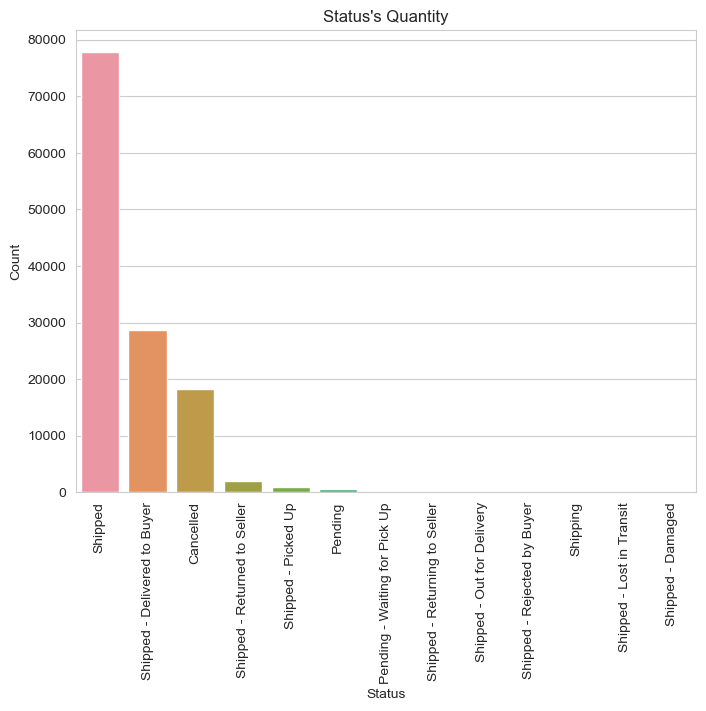

In [14]:
#Visualizations
# Bar plot
# Group the data by Status and calculate the sum of the Amount column

status_counts = final_data["Status"].value_counts()

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
sns.set_palette("Greens_d")

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=status_counts.index, y=status_counts.values,ax=ax)

ax.set_xlabel("Status")
ax.set_ylabel("Count")
ax.set_title("Status's Quantity")
plt.xticks(rotation=90)
plt.title("Status's Quantity")
plt.show()

In [16]:
final_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Qty,128939.0,0.904443,0.313343,0.0,1.000000,1.0,1.000000,15.0
Stock_0,128939.0,64.420773,140.330383,0.0,4.000000,12.0,59.000000,1234.0
Stock_avg,128939.0,68.513515,139.387837,0.0,5.000000,18.0,68.516496,1234.0
Stock_category,128939.0,68.897355,139.494205,0.0,5.000000,18.0,75.000000,1234.0
Amount_0,128939.0,609.381896,313.357517,0.0,413.000000,583.0,771.000000,5584.0
Amount_avg,128939.0,648.580583,272.589488,0.0,459.000000,635.0,771.000000,5584.0
Amount_category,128939.0,648.737307,276.097396,0.0,455.927108,612.0,788.000000,5584.0


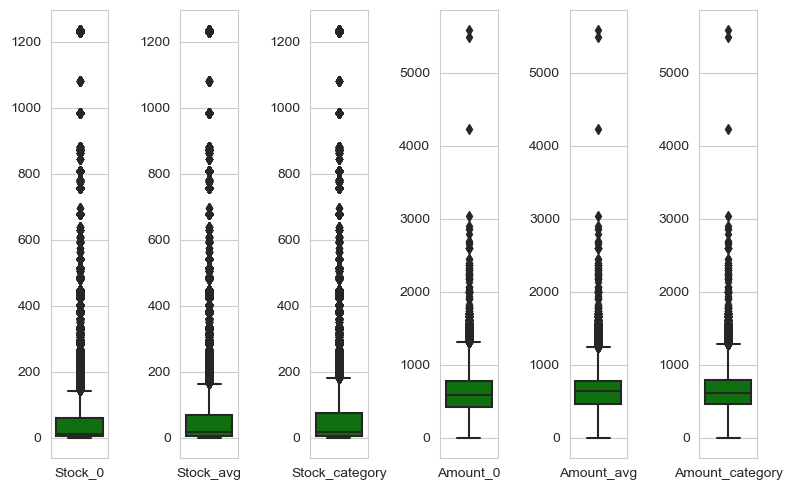

In [17]:
# Box Plot

numeric_cols = ["Stock_0","Stock_avg","Stock_category","Amount_0","Amount_avg","Amount_category"]
numeric_df = final_data.loc[:, final_data.columns.isin(numeric_cols)]
numeric_data = numeric_df.columns.values
columns_cnt=len(numeric_cols)
rows_cnt = len(final_data)
plt.figure(figsize=(8, 5))
for i in range(0,columns_cnt):
    plt.subplot(1, columns_cnt, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data=numeric_df[[numeric_data[i]]], color='green', orient='v')
    plt.tight_layout()

In [18]:
#### Create Promo IDs into a Y/N to compare ####

conditions = [
    (final_data['promotion-ids'] == 'No Promotion'),
    (final_data['promotion-ids'] != 'No Promotion')
]

values = ['No', 'Yes']

final_data['promo_y_n'] = np.select(conditions, values)

conditions2 = [
    (final_data['Status'] == 'Cancelled'),
    (final_data['Status'] != 'Cancelled')
]

values2 = ['Yes', 'No']

final_data['cancelled_y_n'] = np.select(conditions2, values2)

conditions3 = [
    (final_data['cancelled_y_n'] == 'Yes'),
    (final_data['cancelled_y_n'] != 'No')
]

values3 = [1, 0]

final_data['cancelled_bin'] = np.select(conditions3, values3)

final_data.dtypes 
    

index                         object
Order_ID                      object
Date                  datetime64[ns]
Status                        object
Fulfilment                    object
Sales_Channel                 object
ship-service-level            object
Style                         object
SKU                           object
Category                      object
Size                          object
ASIN                          object
Qty                            int64
Amount                        object
ship-city                     object
ship-state                    object
ship-postal-code              object
promotion-ids                 object
B2B                             bool
fulfilled-by                  object
Stock                         object
Color                         object
Stock_0                      float64
Stock_avg                    float64
Stock_category               float64
Amount_0                     float64
Amount_avg                   float64
A

In [19]:
#### Create another dataframe with the same data to manipulate and test our predictions later ####

final_data_test = final_data
final_data_test

,index,Order_ID,Date,Status,Fulfilment,Sales_Channel,ship-service-level,Style,SKU,Category,...,Color,Stock_0,Stock_avg,Stock_category,Amount_0,Amount_avg,Amount_category,promo_y_n,cancelled_y_n,cancelled_bin
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,White,32.0,32.0,32.0,647.62,647.62,647.62,No,Yes,1
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,Green,96.0,96.0,96.0,406.00,406.00,406.00,Yes,No,0
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,Light Green,4.0,4.0,4.0,329.00,329.00,329.00,Yes,No,0
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,Blue,193.0,193.0,193.0,753.33,753.33,753.33,No,Yes,1
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,Pink,6.0,6.0,6.0,574.00,574.00,574.00,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,128970,406-6001380-7673107,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,...,Mauve,69.0,69.0,69.0,517.00,517.00,517.00,No,No,0
128971,128971,402-9551604-7544318,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,...,Black,7.0,7.0,7.0,999.00,999.00,999.00,Yes,No,0
128972,128972,407-9547469-3152358,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,...,Black,27.0,27.0,27.0,690.00,690.00,690.00,No,No,0
128973,128973,402-6184140-0545956,2022-05-31,Shipped,Amazon,Amazon.in,Expedited,J0012,J0012-SKD-XS,Set,...,Green,93.0,93.0,93.0,1199.00,1199.00,1199.00,Yes,No,0


In [20]:
pd.pivot_table(data = final_data, index = ['cancelled_y_n', 'promo_y_n'] \
               , values = ['Order_ID','Stock_category', 'Amount_0'] \
               , aggfunc={'Order_ID':'count', 'Stock_category': np.sum}).rename(columns=
                                                                              {'Order_ID': 'num_orders', 'Stock_category': 'total_stock'})

num_orders   total_stock
cancelled_y_n promo_y_n                          
No            No              31114  2.824240e+06
              Yes             79500  4.749569e+06
Yes           No              18031  1.282878e+06
              Yes               294  2.686863e+04

No     18031
Yes      294
Name: promo_y_n, dtype: int64

Text(0.5, 1.0, '% of Cancelled Items vs. Promotion ID')

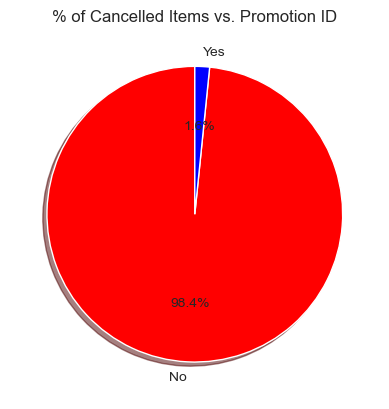

In [21]:
cancelled = final_data[(final_data.cancelled_y_n == 'Yes')]

cancelled_counts = cancelled["promo_y_n"].value_counts()

display(cancelled_counts)

plt.pie(cancelled_counts.values, colors=('r','b'), explode=(0.0,0.0), labels=cancelled_counts.index, autopct='%1.1f%%', 
       shadow=True, startangle=90) 
plt.title("% of Cancelled Items vs. Promotion ID")

In [22]:
# Dummy code for the categorical variables #
final_data = pd.get_dummies(final_data, columns=['Fulfilment', 'Sales_Channel', 'ship-service-level', 
                                                'Style', 'Category', 'Size', 'ship-state', 'B2B', 'fulfilled-by',
                                                'Color', 'promo_y_n'])

In [23]:
final_data.columns

Index(['index', 'Order_ID', 'Date', 'Status', 'SKU', 'ASIN', 'Qty', 'Amount',
       'ship-city', 'ship-postal-code',
       ...
       'Color_Teal', 'Color_Teal Green', 'Color_Turquoise',
       'Color_Turquoise Blue', 'Color_Turquoise Green', 'Color_White',
       'Color_Wine', 'Color_Yellow', 'promo_y_n_No', 'promo_y_n_Yes'],
      dtype='object', length=1555)

In [24]:
pd.options.display.float_format = '{:.2f}'.format

X = final_data.drop(['index', 'Status', 'Order_ID', 'Date', 'SKU', 'ASIN', 'Amount', 'ship-city', 'ship-postal-code', 
                    'promotion-ids', 'Stock', 'cancelled_y_n'], axis=1)
y = final_data['cancelled_y_n']

bestfeatures = SelectKBest(score_func= chi2, k=100)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
print(featureScores.nlargest(50,'Score'))  

                          Features      Score
4                         Amount_0 1885171.51
7                    cancelled_bin  110614.00
1541                  promo_y_n_No   20364.79
1542                 promo_y_n_Yes   12542.64
0                              Qty    8385.10
3                   Stock_category    2057.13
1                          Stock_0    2052.79
2                        Stock_avg    1996.75
5                       Amount_avg     380.25
9              Fulfilment_Merchant     341.04
1478        fulfilled-by_Easy Ship     341.04
13     ship-service-level_Standard     279.14
6                  Amount_category     189.52
8                Fulfilment_Amazon     149.32
1479    fulfilled-by_Not Easy Ship     149.32
12    ship-service-level_Expedited     127.13
1431             ship-state_KERALA      71.22
1405                       Size_XS      56.77
1393                  Category_Top      42.05
1396                      Size_3XL      32.03
707                  Style_JNE3608

In [25]:
best_cols = (featureScores[(featureScores.Score >= 1000)])
best_cols = best_cols.drop(columns=['Score'])
best_cols

,Features
0,Qty
1,Stock_0
2,Stock_avg
3,Stock_category
4,Amount_0
7,cancelled_bin
1541,promo_y_n_No
1542,promo_y_n_Yes


In [26]:
x = final_data[['Qty', 'Stock_category', 'promo_y_n_No']]
y = final_data['cancelled_y_n']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

In [27]:
smote = SMOTE(random_state = 16)
xTrain_SMOTE, yTrain_SMOTE = smote.fit_resample(x_train, y_train)

In [28]:
# Random Forest #
rf = RandomForestClassifier(n_estimators=20, random_state=27)
rf.fit(x_train, y_train)

train_pred = rf.predict(x_train)
rf_train_accuracy = metrics.accuracy_score(y_train, train_pred)

test_pred = rf.predict(x_test)
rf_test_accuracy = metrics.accuracy_score(y_test, test_pred)

# K-Nearest Neighbors #

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

knn_train_pred = knn.predict(x_train)
knn_train_pred_accuracy = metrics.accuracy_score(y_train, knn_train_pred)

knn_test_pred = knn.predict(x_test)
knn_test_pred_accuracy = metrics.accuracy_score(y_test, knn_test_pred)

data = {'train_acc': [rf_train_accuracy, knn_train_pred_accuracy],
       'test_acc': [rf_test_accuracy, knn_test_pred_accuracy]
       }
    
df_report_3 = pd.DataFrame(data, index=['random_forest', 'knn'])

df_report_3

,train_acc,test_acc
random_forest,0.96,0.96
knn,0.94,0.94


In [29]:
#SMOTE RF & KNN
rf_SMOTE = RandomForestClassifier(n_estimators=100, random_state=27)
rf_SMOTE.fit(xTrain_SMOTE, yTrain_SMOTE)

SMtrain_pred = rf_SMOTE.predict(xTrain_SMOTE)
SMrf_train_accuracy = metrics.accuracy_score(yTrain_SMOTE, SMtrain_pred)

SMtest_pred = rf_SMOTE.predict(x_test)
SMrf_test_accuracy = metrics.accuracy_score(y_test, SMtest_pred)

# K-Nearest Neighbors #

knn_SMOTE = KNeighborsClassifier()
knn_SMOTE.fit(xTrain_SMOTE, yTrain_SMOTE)

SMknn_train_pred = knn_SMOTE.predict(xTrain_SMOTE)
SMknn_train_pred_accuracy = metrics.accuracy_score(yTrain_SMOTE, SMknn_train_pred)

SMknn_test_pred = knn_SMOTE.predict(x_test)
SMknn_test_pred_accuracy = metrics.accuracy_score(y_test, SMknn_test_pred)

data = {'SMOTE train_acc': [SMrf_train_accuracy, SMknn_train_pred_accuracy],
       'SMOTE test_acc': [SMrf_test_accuracy, SMknn_test_pred_accuracy]
       }
    
df_report_3 = pd.DataFrame(data, index=['random_forest', 'knn'])

df_report_3


,SMOTE train_acc,SMOTE test_acc
random_forest,0.88,0.83
knn,0.85,0.94


In [30]:
# K-fold Cross validation

# Random Forest #
scores = cross_val_score(rf, x_train, y_train, cv = 10)
# Print the accuracy for each fold:
print("Random Forest 10-Fold CV scores:", scores)
print()
# And the mean accuracy of all 10 folds:
print("Random Forest Average from 10 fold CV:", scores.mean())
print()

# K-Nearest Neighbors #

scores_k = cross_val_score(knn, x_train, y_train, cv = 10)
# Print the accuracy for each fold:
print("KNN 10-Fold CV scores:", scores_k)
print()
# And the mean accuracy of all 10 folds:
print("KNN Average from 10 fold CV:", scores_k.mean())
print()


Random Forest 10-Fold CV scores: [0.95235985 0.955462   0.9566807  0.95457567 0.95823177 0.95391092
 0.95557279 0.95390582 0.95700831 0.95368421]

Random Forest Average from 10 fold CV: 0.9551392045018607

KNN 10-Fold CV scores: [0.94970086 0.94083758 0.94582318 0.94715267 0.94737425 0.93574119
 0.93828939 0.93684211 0.95213296 0.93939058]

KNN Average from 10 fold CV: 0.9433284773504429



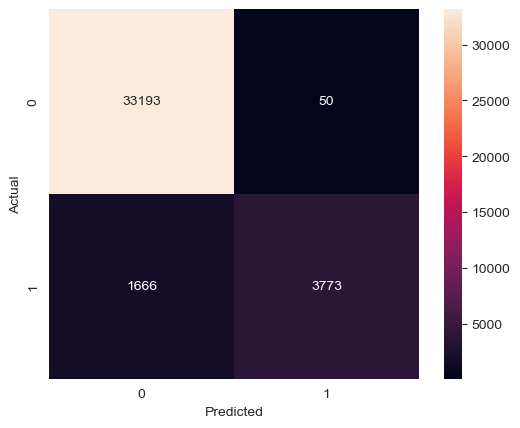

Random Forest Accuracy: 0.9556382813711803


In [31]:
# Create the confusion matrix

conf= confusion_matrix(y_test, test_pred)
sns.heatmap(conf, annot=True, fmt=".0f", square = True);
plt.ylabel('Actual');
plt.xlabel('Predicted');
plt.show()

print("Random Forest Accuracy:",metrics.accuracy_score(y_test, test_pred))

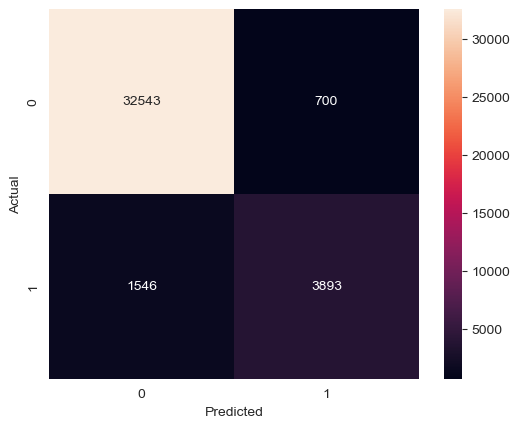

K-Nearest Neighbor Accuracy: 0.9419368181583165


In [32]:
# Create the confusion matrix

conf= confusion_matrix(y_test, knn_test_pred)
sns.heatmap(conf, annot=True, fmt=".0f", square = True);
plt.ylabel('Actual');
plt.xlabel('Predicted');
plt.show()

print("K-Nearest Neighbor Accuracy:",metrics.accuracy_score(y_test, knn_test_pred))


In [33]:
#SLR
final_data.head(5)

,index,Order_ID,Date,Status,SKU,ASIN,Qty,Amount,ship-city,ship-postal-code,...,Color_Teal,Color_Teal Green,Color_Turquoise,Color_Turquoise Blue,Color_Turquoise Green,Color_White,Color_Wine,Color_Yellow,promo_y_n_No,promo_y_n_Yes
0,0,405-8078784-5731545,2022-04-30,Cancelled,SET389-KR-NP-S,B09KXVBD7Z,0,647.62,MUMBAI,400081.00,...,0,0,0,0,0,1,0,0,1,0
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,JNE3781-KR-XXXL,B09K3WFS32,1,406.00,BENGALURU,560085.00,...,0,0,0,0,0,0,0,0,0,1
2,2,404-0687676-7273146,2022-04-30,Shipped,JNE3371-KR-XL,B07WV4JV4D,1,329.00,NAVI MUMBAI,410210.00,...,0,0,0,0,0,0,0,0,0,1
3,3,403-9615377-8133951,2022-04-30,Cancelled,J0341-DR-L,B099NRCT7B,0,753.33,PUDUCHERRY,605008.00,...,0,0,0,0,0,0,0,0,1,0
4,4,407-1069790-7240320,2022-04-30,Shipped,JNE3671-TU-XXXL,B098714BZP,1,574.00,CHENNAI,600073.00,...,0,0,0,0,0,0,0,0,1,0


In [34]:
final_data.columns

Index(['index', 'Order_ID', 'Date', 'Status', 'SKU', 'ASIN', 'Qty', 'Amount',
       'ship-city', 'ship-postal-code',
       ...
       'Color_Teal', 'Color_Teal Green', 'Color_Turquoise',
       'Color_Turquoise Blue', 'Color_Turquoise Green', 'Color_White',
       'Color_Wine', 'Color_Yellow', 'promo_y_n_No', 'promo_y_n_Yes'],
      dtype='object', length=1555)

In [35]:
final_data.dtypes

index                    object
Order_ID                 object
Date             datetime64[ns]
Status                   object
SKU                      object
                      ...      
Color_White               uint8
Color_Wine                uint8
Color_Yellow              uint8
promo_y_n_No              uint8
promo_y_n_Yes             uint8
Length: 1555, dtype: object

In [36]:
x = final_data[['Qty', 'Stock_category', 'promo_y_n_No']]
y = final_data['cancelled_bin']
X = sm.add_constant(x)
m0 = sm.OLS(y,X).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cancelled_bin   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 7.905e+04
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:06:14   Log-Likelihood:                 19988.
No. Observations:              128939   AIC:                        -3.997e+04
Df Residuals:                  128935   BIC:                        -3.993e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7626      0.002    356.922      0.000       0.758       0.767
Qty               -0.7580      0.002   -378.531      0.000      -0.762      -0.754
Stock_category  -1.01e-05   4.16e-06     -2.429      0.015   -1.82e-05   -1.95e-06
promo_y_n_No       0.1727      0.001    133.183      0.000       0.170       0.175
==============================================================================
Omnibus:                   138507.580   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50235542.103
Skew:                           4.881   Prob(JB):                         0.00
Kurtosis:                      99.204   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
#Train test
x = final_data[['Qty', 'Stock_category', 'promo_y_n_No']]
y = final_data['cancelled_bin']

In [38]:
#Divide for testing and training
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30)

In [39]:
RLR = LinearRegression().fit(xtrain, ytrain)
ytrainpred = RLR.predict(xtrain)
ytestpred = RLR.predict(xtest)

In [40]:
pd.DataFrame(list(zip(ytrain, ytrainpred)), columns=['ytrain', 'ytrainhat']).head(5)

,ytrain,ytrainhat
0,0,0.00
1,0,0.00
2,1,0.94
3,0,0.00
4,0,0.00


In [41]:
pd.DataFrame(list(zip(ytest, ytestpred)), columns=['ytest', 'ytesthat']).head(5)

,ytest,ytesthat
0,0,0.00
1,0,0.00
2,1,0.94
3,0,0.00
4,0,0.17


In [42]:
#R2
testr2 = metrics.r2_score(ytest, ytestpred)
trainr2 = metrics.r2_score(ytrain, ytrainpred)
print('RLR test vs train R2:', testr2, trainr2)

RLR test vs train R2: 0.6442850856958313 0.6492646234404555


In [43]:
#MSE
testMSE = metrics.mean_squared_error(ytest, ytestpred)
trainMSE = metrics.mean_squared_error(ytrain, ytrainpred)
print('RLR test vs train MSE:', testMSE, trainMSE)

RLR test vs train MSE: 0.042851378767331715 0.04298088740061833


In [44]:
lm = LinearRegression()
scores = cross_val_score(lm, xtrain, ytrain, scoring='r2', cv = 10)
print("Linear Regression 10-fold scores:", scores)

print("KNN Average from 10 fold CV:", scores.mean())

Linear Regression 10-fold scores: [0.66512691 0.66959989 0.55038853 0.6830959  0.67614259 0.62071592
 0.64698158 0.65618112 0.6683212  0.64874019]
KNN Average from 10 fold CV: 0.6485293826753445


In [45]:
final_data[['Qty', 'Stock_category', 'promo_y_n_No']]

,Qty,Stock_category,promo_y_n_No
0,0,32.00,1
1,1,96.00,0
2,1,4.00,0
3,0,193.00,1
4,1,6.00,1
...,...,...,...
128970,1,69.00,1
128971,1,7.00,0
128972,1,27.00,1
128973,1,93.00,0


In [46]:
df_encoded = final_data[['Qty', 'Stock_category', 'promo_y_n_No', 'cancelled_bin']]
df_encoded.head()

,Qty,Stock_category,promo_y_n_No,cancelled_bin
0,0,32.00,1,1
1,1,96.00,0,0
2,1,4.00,0,0
3,0,193.00,1,1
4,1,6.00,1,0


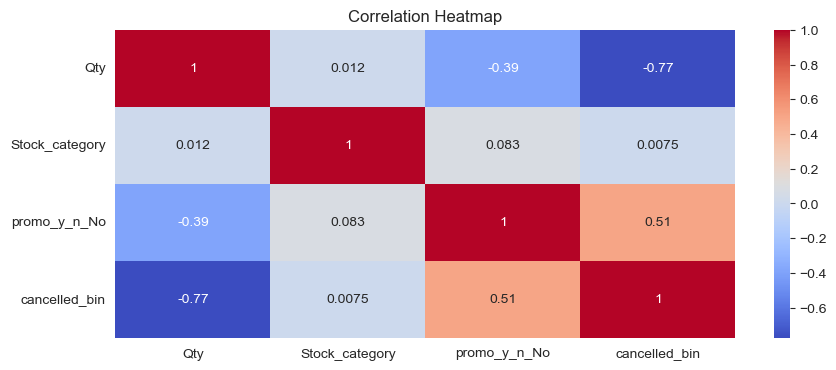

In [47]:
#Correlation heatmap
df_corr = final_data[['Qty', 'Stock_category', 'promo_y_n_No', 'cancelled_bin']]

#Setting plot size
plt.figure(figsize=(10,4))

#Creating plot
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')

#Assigning plot title
plt.title('Correlation Heatmap')

#Printing plot
plt.show()

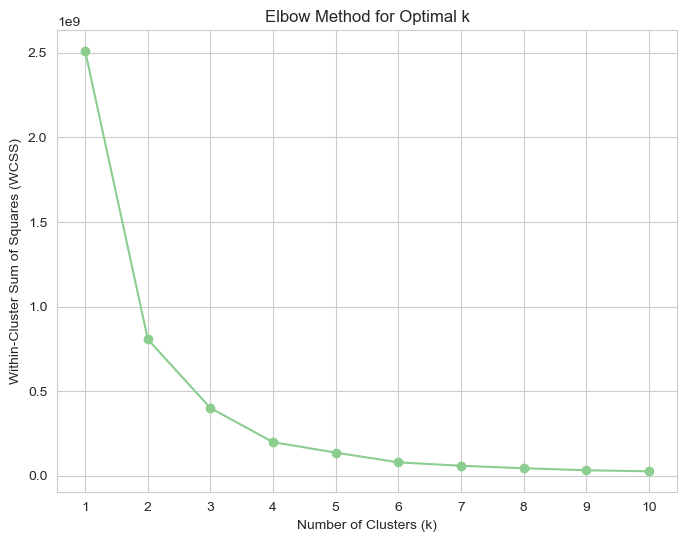

In [48]:
# Elbow Method
df_encoded = final_data[['Qty', 'Stock_category', 'promo_y_n_No', 'cancelled_bin']]
df_encoded.head()
wcss = []
max_clusters = 10
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_encoded)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [49]:
# Predict
kmeanModel = KMeans(n_clusters=2, random_state=0)
kmeanModel.fit(df_encoded)
df_encoded['clusters'] = kmeanModel.predict(df_encoded)
pd.set_option('display.max_columns', None)
df_encoded.head()

,Qty,Stock_category,promo_y_n_No,cancelled_bin,clusters
0,0,32.00,1,1,0
1,1,96.00,0,0,0
2,1,4.00,0,0,0
3,0,193.00,1,1,0
4,1,6.00,1,0,0


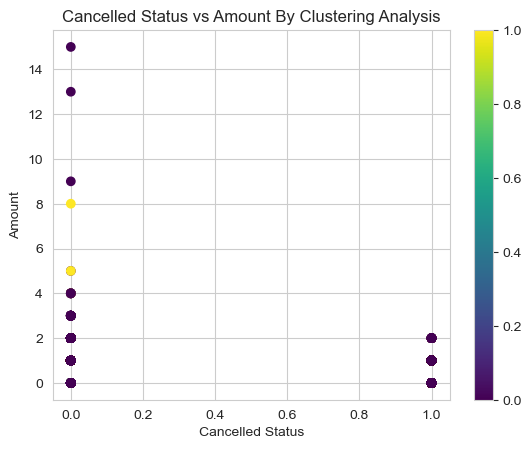

In [50]:
plt.scatter(df_encoded['cancelled_bin'], df_encoded['Qty'], c=df_encoded['clusters'], cmap='viridis')
plt.colorbar()
plt.xlabel('Cancelled Status')
plt.ylabel('Amount')
plt.title('Cancelled Status vs Amount By Clustering Analysis')
plt.show()

<Axes: ylabel='clusters'>

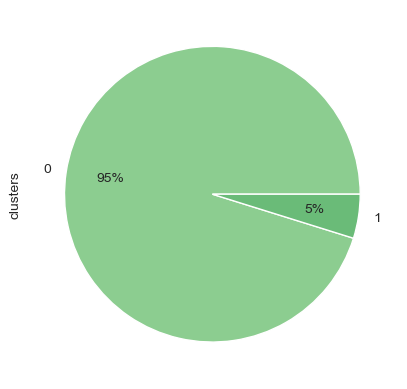

In [51]:
df_encoded['clusters'].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

In [52]:
df_encoded.head()

,Qty,Stock_category,promo_y_n_No,cancelled_bin,clusters
0,0,32.00,1,1,0
1,1,96.00,0,0,0
2,1,4.00,0,0,0
3,0,193.00,1,1,0
4,1,6.00,1,0,0


In [53]:
# Creating Clusters column to create graphs
clusters=pd.concat([df_encoded, pd.DataFrame({'cluster':df_encoded['clusters']})], axis=1)
clusters.head()

,Qty,Stock_category,promo_y_n_No,cancelled_bin,clusters,cluster
0,0,32.00,1,1,0,0
1,1,96.00,0,0,0,0
2,1,4.00,0,0,0,0
3,0,193.00,1,1,0,0
4,1,6.00,1,0,0,0


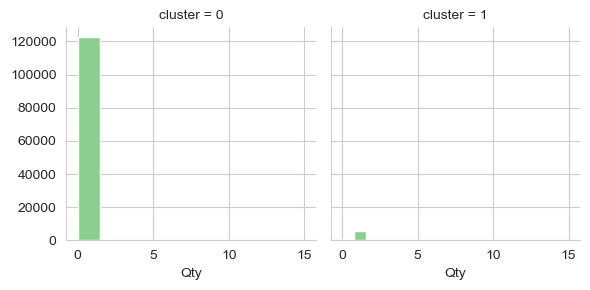

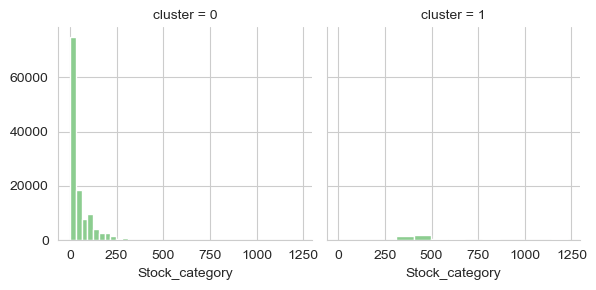

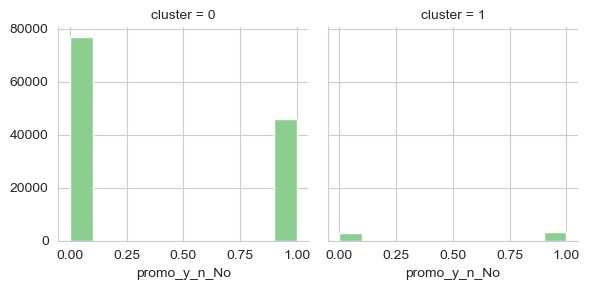

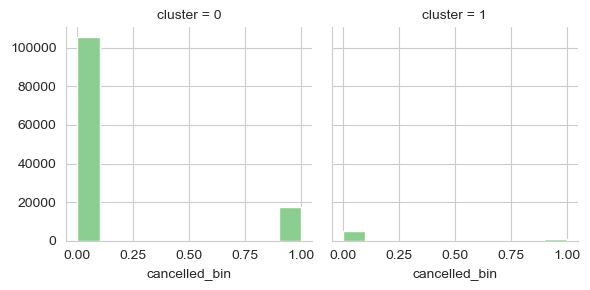

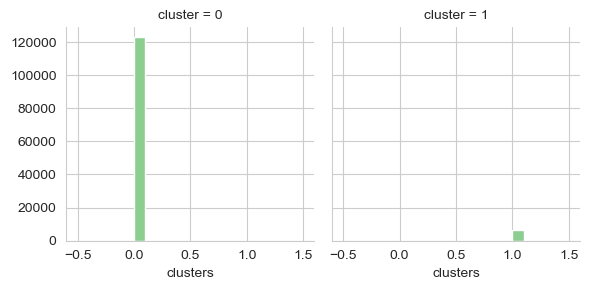

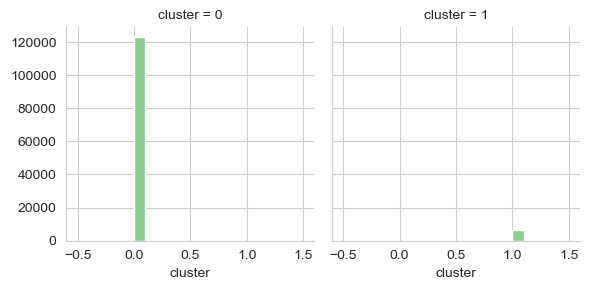

In [54]:
# Interpreting Cluster
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

In [58]:
#### Test of the final Random Forest model to predict if all orders had a promotional id ####

final_data_test.loc[final_data_test['promo_y_n'] == 'No', 'promo_y_n'] = 'Yes'

final_data_test.promo_y_n.value_counts()

Yes    128939
Name: promo_y_n, dtype: int64

In [59]:
# Dummy code for the categorical variables #
final_data_test = pd.get_dummies(final_data_test, columns=['Fulfilment', 'Sales_Channel', 'ship-service-level', 
                                                'Style', 'Category', 'Size', 'ship-state', 'B2B', 'fulfilled-by',
                                                'Color', 'promo_y_n'])

In [62]:
#### Had to update the field promo_y_n_No to promo_y_n_Yes since we have keyed all values as 'Yes' ####

x_promo_yes = final_data_test[['Qty', 'Stock_category', 'promo_y_n_Yes']]
y_promo_yes = final_data_test['cancelled_y_n']

x_train_promo, x_test_promo, y_train_promo, y_test_promo = train_test_split(x_promo_yes, y_promo_yes, test_size = 0.30)

In [63]:
# Random Forest #
rf_promo_yes = RandomForestClassifier(n_estimators=20, random_state=27)
rf_promo_yes.fit(x_train_promo, y_train_promo)

train_pred_promo = rf_promo_yes.predict(x_train_promo)
rf_promo_train_accuracy = metrics.accuracy_score(y_train_promo, train_pred_promo)

test_pred_promo = rf_promo_yes.predict(x_test_promo)
rf_promo_test_accuracy = metrics.accuracy_score(y_test_promo, test_pred_promo)

data_promo = {'train_acc': [rf_promo_train_accuracy],
               'test_acc': [rf_promo_test_accuracy]
       }
    
df_report_promo = pd.DataFrame(data_promo, index=['random_forest'])

df_report_promo

,train_acc,test_acc
random_forest,0.96,0.96


In [67]:
#test_pred_promo

unique, counts = np.unique(test_pred_promo, return_counts=True)

dict(zip(unique, counts))

{'No': 34826, 'Yes': 3856}

In [68]:
#### This is the percentage of items that are not cancelled with 100% having promotional id ####

34826/(34826+3856)

0.9003153921720697